# DNS LOAN PREDICTION CHALLENGE

In [0]:
%load_ext watermark
%watermark -d -m -v -p numpy,matplotlib,sklearn,eli5,seaborn,yellowbrick,statsmodels,patsy,xgboost,pandas -g

2019-02-08 

CPython 3.6.5
IPython 6.4.0

numpy 1.15.4
matplotlib 2.2.2
sklearn 0.20.2
eli5 0.8
seaborn 0.9.0
yellowbrick 0.8
statsmodels 0.9.0
patsy 0.5.0
xgboost 0.81
pandas 0.23.0

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 61 Stepping 4, GenuineIntel
CPU cores  : 4
interpreter: 64bit
Git hash   :


## 1.0 Description of the challenge:

SuperLender is a local digital lending company, which prides itself in its effective use of credit risk models to deliver profitable and high-impact loan alternative. Its assessment approach is based on two main risk drivers of loan default prediction:.
- 1) willingness to pay and 
- 2) ability to pay. Since not all customers pay back, the company invests in experienced data scientist to build robust models to effectively predict the odds of repayment.

These two fundamental drivers need to be determined at the point of each application to allow the credit grantor to make a calculated decision based on repayment odds, which in turn determines if an applicant should get a loan, and if so - what the size, price and tenure of the offer will be.

There are two types of risk models in general: New business risk, which would be used to assess the risk of application(s) associated with the first loan that he/she applies. The second is a repeat or behaviour risk model, in which case the customer has been a client and applies for a repeat loan. In the latter case - we will have additional performance on how he/she repaid their prior loans, which we can incorporate into our risk model.

It is your job to predict if a loan was good or bad, i.e. accurately predict binary outcome variable, where Good is 1 and Bad is 0.

### 1.1 Problem

This competition is a supervised classification machine learning task. The objective is to use historical financial and socioeconomic data to predict whether or not an applicant will be able to repay a loan. This is a standard supervised classification task:

* __Supervised__: The labels are included in the training data and the goal is to train a model to learn to predict the labels from the features
* __Classification__: The label is a binary variable, 0 (will repay loan on time), 1 (will have difficulty repaying loan)

### 1.2 Description of the data

There are 3 different datasets for both train and test

#### 1.2.1 Demographic data (traindemographics.csv)
- customerid (Primary key used to merge to other data)
- birthdate (date of birth of the customer)
- bank_account_type (type of primary bank account)
- longitude_gps
- latitude_gps
- bank_name_clients (name of the bank)
- bank_branch_clients (location of the branch - not compulsory - so missing in a lot of the cases)
- employment_status_clients (type of employment that customer has)
- level_of_education_clients (highest level of education)

#### 1.2.2 Performance data (trainperf.csv) : 
This is the repeat loan that the customer has taken for which we need to predict the performance of. Basically, we need to predict if whether this loan would default given all previous loans and demographics of a customer.
- customerid (Primary key used to merge to other data)
- systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
- loannumber (The number of the loan that you have to predict)
- approveddate (Date that loan was approved)
- creationdate (Date that loan application was created)
- loanamount (Loan value taken)
- totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees)
- termdays (Term of loan)
- referredby (customerId of the customer that referred this person - is missing, then not referred)
- good_bad_flag (good = settled loan on time; bad = did not settled loan on time) - this is the target variable that we need to predic

#### 1.2.3 Previous loans data (trainprevloans.csv) : 
This dataset contains all previous loans that the customer had prior to the loan above that we want to predict the performance of. Each loan will have a different systemloanid, but the same customerid for each customer.

- customerid (Primary key used to merge to other data)
- systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
- loannumber (The number of the loan that you have to predict)
- approveddate (Date that loan was approved)
- creationdate (Date that loan application was created)
- loanamount (Date that loan application was created)
- totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees) termdays (Term of loan)
- closeddate (Date that the loan was settled)
- referredby (customerId of the customer that referred this person - is missing, then not refrerred)
- firstduedate (Date of first payment due in cases where the term is longer than 30 days. So in the case where the term is 60+ days - then there are multiple monthly payments due - and this dates reflects the date of the first payment)
- firstrepaiddate (Actual date that he/she paid the first payment as defined above)

### 1.3 Setting up the environment

**Python Libraries**

I have used below list of python packages. Kindly note that there many alternative libraries available for same techniques. 

To install a python library type **"pip install"** or those using the anaconda environment **"conda install"**

In [0]:
import pandas as pd                             #import pandas for dataframe manipulation
import numpy as np                              #import numerical python
import seaborn as sns                           #seaborn for visuals
import matplotlib as mpl                        #matplot for plotting
import matplotlib.pyplot as plt                 #matplot for plotting
import itertools
import datetime as dt                           #convert date formats
from scipy import stats                         #statistical analysis


from IPython.display import display             # Allows the use of display() for DataFrames
import warnings                                 # Suppress warnings 
warnings.filterwarnings('ignore') 
import os                                       # File system manangement
import gc                                       # memory managemen

In [0]:
#Setting styles and aesthetics
pd.options.display.max_columns =200
pd.options.display.max_rows =30
pd.options.display.float_format = '{:,.2f}'.format

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18, 8)

# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg'

%matplotlib inline

---

## 2. Introduction

### 2.1 Load The Data

In [0]:
#Read datasets
traindemographics = pd.read_csv('../data/raw/traindemographics.csv', parse_dates=['birthdate'])
testdemographics = pd.read_csv('../data/raw/testdemographics.csv', parse_dates=['birthdate'])
trainperf = pd.read_csv('../data/raw/trainperf.csv', parse_dates=['approveddate','creationdate'])
testperf = pd.read_csv('../data/raw/testperf.csv',parse_dates=['approveddate','creationdate'])
trainprevloans= pd.read_csv('../data/raw/trainprevloans.csv', parse_dates=['approveddate','creationdate','closeddate',
                                                                           'firstduedate','firstrepaiddate'])
testprevloans = pd.read_csv('../data/raw/testprevloans.csv', parse_dates=['approveddate','creationdate','closeddate',
                                                                          'firstduedate','firstrepaiddate'])

### 2.2 Data Dimension

In [0]:
# Check The Shape Of The Data Loaded
print('Test Demographic shape: {} Rows, {} Columns'.format(*trainperf.shape))
print('Test Performance shape: {} Rows, {} Columns'.format(*traindemographics.shape))
print('Test Previous Loan shape: {} Rows, {} Columns'.format(*trainprevloans.shape))
print('Train Demographic shape: {} Rows, {} Columns'.format(*testperf.shape))
print('Train Performance shape: {} Rows, {} Columns'.format(*testdemographics.shape))
print('Train Previous Loan shape: {} Rows, {} Columns'.format(*testprevloans.shape))

Test Demographic shape: 4368 Rows, 10 Columns
Test Performance shape: 4346 Rows, 9 Columns
Test Previous Loan shape: 18183 Rows, 12 Columns
Train Demographic shape: 1450 Rows, 9 Columns
Train Performance shape: 1487 Rows, 9 Columns
Train Previous Loan shape: 5907 Rows, 12 Columns


### 2.3 First Few rows of Data

In [0]:
# Print First Few Rows Of The Data
display("test demographics")
display(testdemographics.head(3))
display("test performance")
display(testperf.head(3))
display("test previous loans")
display(testprevloans.head(3))
display("train demographics")
display(traindemographics.head(3))
display("train performance")
display(trainperf.head(3))
display("train previous loans")
display(trainprevloans.head(3))

'test demographics'

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858f305c8dd672015c93b1db645db4,1976-08-28,Savings,5.30,7.59,Heritage Bank,NaN,Permanent,NaN
1,8a858f085a477386015a47fb049e49ca,1978-06-23,Savings,3.29,6.60,UBA,NaN,Permanent,NaN
2,8a858e6f5cd5e874015cd6f5634c39ad,1984-04-04,Savings,8.50,7.73,First Bank,NaN,Permanent,NaN


'test performance'

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby
0,8a858899538ddb8e015390510b321f08,301998974,4,40:48.0,39:35.0,10000,"12,250.00",30,NaN
1,8a858959537a097401537a4e316e25f7,301963615,10,43:40.0,42:34.0,40000,"44,000.00",30,NaN
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,15:11.0,15:04.0,20000,"24,500.00",30,NaN


'test previous loans'

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a858899538ddb8e015390510b321f08,301621635,3,2016-05-17 10:37:00,2016-05-17 09:36:55,"10,000.00","13,000.00",30,2016-06-17 00:04:15,NaN,2016-06-16,2016-06-16 15:44:08
1,8a858959537a097401537a4e316e25f7,301810201,5,2017-02-04 21:28:59,2017-02-04 20:28:52,"30,000.00","36,800.00",60,2017-03-02 16:22:58,NaN,2017-03-06,2017-03-02 16:07:47
2,8a858959537a097401537a4e316e25f7,301831255,6,2017-03-04 10:28:22,2017-03-04 09:28:16,"30,000.00","34,400.00",30,2017-04-02 00:44:24,NaN,2017-04-03,2017-04-01 21:29:46


'train demographics'

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.32,6.53,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.33,7.12,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.75,5.56,Fidelity Bank,NaN,NaN,NaN


'train performance'

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,"30,000.00","34,500.00",30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41,2017-07-05 16:04:18,"15,000.00","17,250.00",30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57,2017-07-06 13:52:51,"20,000.00","22,250.00",15,NaN,Good


'train previous loans'

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40,2016-08-15 17:22:32,"10,000.00","13,000.00",30,2016-09-01 16:06:48,NaN,2016-09-14,2016-09-01 15:51:43
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07,2017-04-28 17:38:53,"10,000.00","13,000.00",30,2017-05-28 14:44:49,NaN,2017-05-30,2017-05-26 00:00:00
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25,2017-03-05 09:56:19,"20,000.00","23,800.00",30,2017-04-26 22:18:56,NaN,2017-04-04,2017-04-26 22:03:47


---

## 3 Data Exploration

### 3.1 Get first hand feeling of the data

#### 3.1.1 Column/Variable Names
Variable names of the data. You may create your own variable names.

In [0]:
display("test demographics")
display(testdemographics.columns)
display("test performance")
display(testperf.columns)
display("test previous loans")
display(testprevloans.columns)
display("train demographics")
display(traindemographics.columns)
display("train performance")
display(trainperf.columns)
display("train previous loans")
display(trainprevloans.columns)

'test demographics'

Index(['customerid', 'birthdate', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'bank_branch_clients',
       'employment_status_clients', 'level_of_education_clients'],
      dtype='object')

'test performance'

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'referredby'],
      dtype='object')

'test previous loans'

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'closeddate',
       'referredby', 'firstduedate', 'firstrepaiddate'],
      dtype='object')

'train demographics'

Index(['customerid', 'birthdate', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'bank_branch_clients',
       'employment_status_clients', 'level_of_education_clients'],
      dtype='object')

'train performance'

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'referredby',
       'good_bad_flag'],
      dtype='object')

'train previous loans'

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'closeddate',
       'referredby', 'firstduedate', 'firstrepaiddate'],
      dtype='object')

Let's look at the number of columns of each data type. int64 and float64 are numeric variables (which can be either discrete or continuous). object columns contain strings and are categorical features.

In [0]:
# Number of each type of column
display("test demographics")
display(testdemographics.dtypes.value_counts())
display("test performance")
display(testperf.dtypes.value_counts())
display("test previous loans")
display(testprevloans.dtypes.value_counts())
display("train demographics")
display(traindemographics.dtypes.value_counts())
display("train performance")
display(trainperf.dtypes.value_counts())
display("train previous loans")
display(trainprevloans.dtypes.value_counts())

'test demographics'

object            6
float64           2
datetime64[ns]    1
dtype: int64

'test performance'

int64      4
object     4
float64    1
dtype: int64

'test previous loans'

datetime64[ns]    5
int64             3
object            2
float64           2
dtype: int64

'train demographics'

object            6
float64           2
datetime64[ns]    1
dtype: int64

'train performance'

object            3
int64             3
float64           2
datetime64[ns]    2
dtype: int64

'train previous loans'

datetime64[ns]    5
int64             3
object            2
float64           2
dtype: int64

#### 3.1.2 Structure of the Data

Use pandas profiling to get summary details of each dataset

In [0]:
import pandas_profiling

In [0]:
#profile = pandas_profiling.ProfileReport(testdemographics)
#profile.to_file(outputfile="../reports/html/testdemographics.html")

In [0]:
#profile = pandas_profiling.ProfileReport(testperf)
#profile.to_file(outputfile="../reports/html/testperf.html")

In [0]:
#profile = pandas_profiling.ProfileReport(testprevloans)
#profile.to_file(outputfile="../reports/html/testprevloans.html")

In [0]:
#profile = pandas_profiling.ProfileReport(traindemographics)
#profile.to_file(outputfile="../reports/html/traindemographics.html")

In [0]:
#profile = pandas_profiling.ProfileReport(trainperf)
#profile.to_file(outputfile="../reports/html/trainperf.html")

In [0]:
#profile = pandas_profiling.ProfileReport(trainprevloans)
#profile.to_file(outputfile="../reports/html/trainprevloans.html")

---

## 4.0 Data Preparation

### 4.1 Merge the datasets

tag the data with a set column specifying whether its from train or test set

In [0]:
traindemographics['set'] = 'train'
testdemographics['set'] = 'test'
trainperf['set'] = 'train'
testperf['set'] = 'test'
trainprevloans['set'] = 'train'
testprevloans['set'] = 'test'

In [0]:
Tdemographics=pd.concat([traindemographics,testdemographics])
Tperfomance=pd.concat([trainperf,testperf])
Tprevious=pd.concat([trainprevloans,testprevloans])

### 4.2. Create the TARGET Variable 

In [0]:
# Convert the good_bad_flag into numerical binary variable 
goodbad={'Good':1,'Bad':0}
Tperfomance.good_bad_flag=Tperfomance.good_bad_flag.map(goodbad)

In [0]:
Tperfomance.head()

,approveddate,creationdate,customerid,good_bad_flag,loanamount,loannumber,referredby,set,systemloanid,termdays,totaldue
0,2017-07-25 08:22:56,2017-07-25 07:22:47,8a2a81a74ce8c05d014cfb32a0da1049,1.00,"30,000.00",12,NaN,train,301994762,30,"34,500.00"
1,2017-07-05 17:04:41,2017-07-05 16:04:18,8a85886e54beabf90154c0a29ae757c0,1.00,"15,000.00",2,NaN,train,301965204,30,"17,250.00"
2,2017-07-06 14:52:57,2017-07-06 13:52:51,8a8588f35438fe12015444567666018e,1.00,"20,000.00",7,NaN,train,301966580,15,"22,250.00"
3,2017-07-27 19:00:41,2017-07-27 18:00:35,8a85890754145ace015429211b513e16,1.00,"10,000.00",3,NaN,train,301999343,15,"11,500.00"
4,2017-07-03 23:42:45,2017-07-03 22:42:39,8a858970548359cc0154883481981866,1.00,"40,000.00",9,NaN,train,301962360,30,"44,000.00"


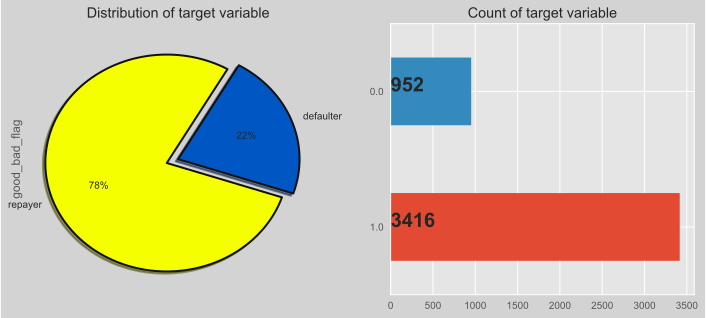

In [0]:
# Distribution of the target variable
fig = plt.figure(figsize=(12, 5))
plt.subplot(121)
Tperfomance[Tperfomance['set'] == "train"]["good_bad_flag"].value_counts().plot.pie(autopct = "%1.0f%%",colors = sns.color_palette("prism",7),
                                                                             startangle = 60,
                                            labels=["repayer","defaulter"],wedgeprops={"linewidth":2,"edgecolor":"k"},
                                            explode=[.1,0],shadow =True)
plt.title("Distribution of target variable")

plt.subplot(122)
ax = Tperfomance[Tperfomance['set'] == "train"]["good_bad_flag"].value_counts().plot(kind="barh")

for i,j in enumerate(Tperfomance[Tperfomance['set'] == "train"]["good_bad_flag"].value_counts().values):
    ax.text(.7,i,j,weight = "bold",fontsize=20)

plt.title("Count of target variable")
#ax.set_facecolor("k")
fig.set_facecolor("lightgrey")
plt.show()

### 4.3 Missing Values

#### 4.3.1 Percentage of Missing values in performance train and test data

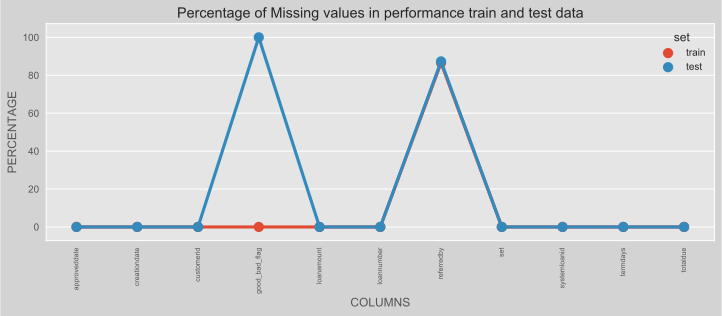

In [0]:
fig = plt.figure(figsize=(12,4))
miss_train = pd.DataFrame((Tperfomance[Tperfomance['set'] == "train"].isnull().sum())*100/Tperfomance[Tperfomance['set'] == "train"].shape[0]).reset_index()
miss_test  = pd.DataFrame((Tperfomance[Tperfomance['set'] == "test"].isnull().sum())*100/Tperfomance[Tperfomance['set'] == "test"].shape[0]).reset_index()
miss_train["set"] = "train"
miss_test["set"]  =  "test"
missing = pd.concat([miss_train,miss_test],axis=0)
ax = sns.pointplot("index",0,data=missing,hue="set")
plt.xticks(rotation =90,fontsize =7)
plt.title("Percentage of Missing values in performance train and test data")
plt.ylabel("PERCENTAGE")
plt.xlabel("COLUMNS")
#ax.set_facecolor("k")
fig.set_facecolor("lightgrey")

#### 4.3.2 Percentage of Missing values in other data sets

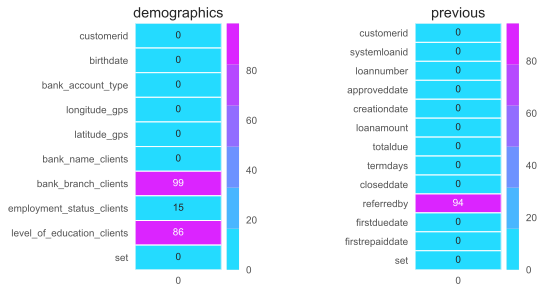

In [0]:
plt.figure(figsize=(12,10))

plt.subplot(231)
sns.heatmap(pd.DataFrame(Tdemographics.isnull().sum()/Tdemographics.shape[0]*100),annot=True,
            cmap=sns.color_palette("cool"),linewidth=1,linecolor="white")
plt.title("demographics")

plt.subplot(232)
sns.heatmap(pd.DataFrame(Tprevious.isnull().sum()/Tprevious.shape[0]*100),annot=True,
            cmap=sns.color_palette("cool"),linewidth=1,linecolor="white")
plt.title("previous")

plt.subplots_adjust(wspace = 1.6)

### 4.4 Feature Engineering

#### 4.4.1 Tdemographics

In [0]:
Tdemographics.head(3)

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,set
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.32,6.53,GT Bank,NaN,NaN,NaN,train
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.33,7.12,Sterling Bank,NaN,Permanent,NaN,train
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.75,5.56,Fidelity Bank,NaN,NaN,NaN,train


In [0]:
Tdemographics.drop_duplicates(subset=Tdemographics.columns,keep='last', inplace=True)

##### 4.4.1.1 Age

In [0]:
Tdemographics['Age']=2018-Tdemographics.birthdate.dt.year

In [0]:
Tdemographics.Age=pd.cut(Tdemographics.Age,[0,13,31,51,100],labels=['ChildAge','YoungAge','MiddleAge','SeniorAge'])

##### 4.4.1.2 bank_account_type (type of primary bank account)

In [0]:
Tdemographics["bank_account_type"].value_counts()

Savings    4570
Other      1168
Current      80
Name: bank_account_type, dtype: int64

In [0]:
Tdemographics["bank_account_type"] = Tdemographics["bank_account_type"].replace("Current", "Other")

In [0]:
Tdemographics["bank_account_type"].value_counts()

Savings    4570
Other      1248
Name: bank_account_type, dtype: int64

In [0]:
pd.crosstab(Tdemographics.employment_status_clients,Tdemographics.bank_account_type,margins=True).style.background_gradient(cmap='summer_r')

bank_account_type,Other,Savings,All
employment_status_clients,,,
Contract,1,1,2
Permanent,813,3392,4205
Retired,2,6,8
Self-Employed,322,148,470
Student,73,116,189
Unemployed,25,54,79
All,1236,3717,4953


##### 4.4.1.3 level_of_education_clients

In [0]:
Tdemographics["level_of_education_clients"].value_counts()

Graduate         576
Secondary        118
Post-Graduate     90
Primary           11
Name: level_of_education_clients, dtype: int64

##### 4.4.1.4 bank_name_clients

In [0]:
Tdemographics["bank_name_clients"].value_counts()

GT Bank               2128
First Bank             790
Access Bank            567
UBA                    461
Zenith Bank            412
Diamond Bank           392
EcoBank                202
Stanbic IBTC           193
FCMB                   168
Skye Bank              146
Fidelity Bank          139
Sterling Bank           67
Wema Bank               37
Union Bank              36
Heritage Bank           27
Keystone Bank           25
Standard Chartered      19
Unity Bank               9
Name: bank_name_clients, dtype: int64

**<font color="red">high cardinality will drop the variable**

##### 4.4.1.5 bank_branch_clients

In [0]:
Tdemographics["bank_branch_clients"].value_counts()

HEAD OFFICE                                                       3
APAPA                                                             3
OGBA                                                              3
OBA AKRAN                                                         3
AJOSE ADEOGUN                                                     2
OREGUN                                                            2
DUGBE,IBADAN                                                      1
TRANS AMADI                                                       1
MEDICAL ROAD IKEJA                                                1
GBAGADA                                                           1
LAGOS                                                             1
KEFFI BRANCH IKOYI                                                1
OBA ADEBIMPE                                                      1
PLOT 999C DANMOLE STREET, ADEOLA ODEKU, VICTORIA ISLAND, LAGOS    1
LADIPO                                          

**<font color="red">high cardinality will drop the variable**

##### 4.4.1.6 employment_status_clients

In [0]:
Tdemographics["employment_status_clients"].value_counts()

Permanent        4205
Self-Employed     470
Student           189
Unemployed         79
Retired             8
Contract            2
Name: employment_status_clients, dtype: int64

#### 4.4.1.7 bank_name_clients

In [0]:
Tdemographics["bank_name_clients"].value_counts()

GT Bank               2128
First Bank             790
Access Bank            567
UBA                    461
Zenith Bank            412
Diamond Bank           392
EcoBank                202
Stanbic IBTC           193
FCMB                   168
Skye Bank              146
Fidelity Bank          139
Sterling Bank           67
Wema Bank               37
Union Bank              36
Heritage Bank           27
Keystone Bank           25
Standard Chartered      19
Unity Bank               9
Name: bank_name_clients, dtype: int64

Ok, there, the names will be useless to the algo, and replace them with digital is meaningless, and I do not want to binarize this variable, the cardinality is too great. So we will seek to characterize this variable with external data, such as liquidity ratios, blah (thanks to HB)

In [0]:
Liquidity_Ratio = pd.read_csv("../data/external/Nigerian_Banks_Liquidity_Ratio_Efficiency_Ratio_and_Profitability.csv", sep=";")

In [0]:
Liquidity_Ratio.head(3)

,S_N,Bank,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Loan_to_Asset
0,1,First Bank,0.10,0.01,1.12,0.96,0.89,0.08,0.65
1,2,UBA,0.10,0.01,1.04,0.93,0.49,0.33,0.34
2,3,Zenith Bank,0.09,0.03,1.12,0.93,0.64,0.14,0.47


That's it, we'll merge that with the basic dataset, using as the primary key the name of the banks

In [0]:
Tdemographics = pd.merge(Tdemographics, Liquidity_Ratio, how = 'left', left_on = 'bank_name_clients', right_on = 'Bank')

In [0]:
Tdemographics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5818 entries, 0 to 5817
Data columns (total 20 columns):
customerid                    5818 non-null object
birthdate                     5818 non-null datetime64[ns]
bank_account_type             5818 non-null object
longitude_gps                 5818 non-null float64
latitude_gps                  5818 non-null float64
bank_name_clients             5818 non-null object
bank_branch_clients           65 non-null object
employment_status_clients     4953 non-null object
level_of_education_clients    795 non-null object
set                           5818 non-null object
Age                           5818 non-null category
S_N                           5579 non-null float64
Bank                          5579 non-null object
Return_On_Equity              5579 non-null float64
Return_On_Asset               5579 non-null float64
Current_Ratio                 5579 non-null float64
Liquid_to_asset_Ratio         5579 non-null float64
Loan_to_Depo

Flute, lines did not have girlfriends in the dataframe "Liquidity_Ratio"
Let's check who it is

In [0]:
Tdemographics[Tdemographics["Current_Ratio"].isnull()]["bank_name_clients"].unique()

array(['FCMB', 'Standard Chartered', 'Heritage Bank', 'Keystone Bank'],
      dtype=object)

Yes, these 4 banks do not exist in the Liquidity_Ratio database, we will fill in the missing values ​​later

We take the opportunity to add another table to characterize banks, it's always nice

In [0]:
data_deposit = pd.read_csv("../data/external/Data_25_deposit_commercial_banks_Nigeria_2005.csv", sep=";")

In [0]:
data_deposit.head(3)

,Bank names,Status,Time,Merger,Age,Revenue,Asset
0,Access Bank,0,10,0,26,258.00,"2,590.00"
1,AfribankPlc*,1,7,0,52,0.24,"1,010.00"
2,Diamond Bank,0,10,1,25,6.22,"1,750.00"


In [0]:
Tdemographics = pd.merge(Tdemographics, data_deposit, how = 'left', left_on = 'bank_name_clients', right_on = 'Bank names')
Tdemographics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5818 entries, 0 to 5817
Data columns (total 27 columns):
customerid                    5818 non-null object
birthdate                     5818 non-null datetime64[ns]
bank_account_type             5818 non-null object
longitude_gps                 5818 non-null float64
latitude_gps                  5818 non-null float64
bank_name_clients             5818 non-null object
bank_branch_clients           65 non-null object
employment_status_clients     4953 non-null object
level_of_education_clients    795 non-null object
set                           5818 non-null object
Age_x                         5818 non-null category
S_N                           5579 non-null float64
Bank                          5579 non-null object
Return_On_Equity              5579 non-null float64
Return_On_Asset               5579 non-null float64
Current_Ratio                 5579 non-null float64
Liquid_to_asset_Ratio         5579 non-null float64
Loan_to_Depo

In [0]:
Tdemographics[Tdemographics["Age_y"].isnull()]["bank_name_clients"].unique()

array(['Stanbic IBTC', 'Heritage Bank', 'Keystone Bank'], dtype=object)

Still these three banks that are missing, we will manage that later.
In the meantime, we move on

In [0]:
Tdemographics.head(3)

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,set,Age_x,S_N,Bank,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Loan_to_Asset,Bank names,Status,Time,Merger,Age_y,Revenue,Asset
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.32,6.53,GT Bank,NaN,NaN,NaN,train,MiddleAge,4.00,GT Bank,0.24,0.04,0.99,0.82,0.71,0.32,0.47,GT Bank,0.00,10.00,0.00,25.00,280.10,"2,520.00"
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.33,7.12,Sterling Bank,NaN,Permanent,NaN,train,MiddleAge,8.00,Sterling Bank,0.16,0.01,0.81,0.74,0.46,0.11,0.36,Sterling Bank,0.00,10.00,1.00,56.00,130.60,799.50
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.75,5.56,Fidelity Bank,NaN,NaN,NaN,train,YoungAge,7.00,Fidelity Bank,0.07,0.01,1.24,0.93,0.79,0.13,0.56,Fidelity Bank,0.00,10.00,0.00,27.00,146.90,"1,232.00"


In [0]:
Tdemographics.drop(columns=['bank_name_clients','bank_branch_clients','birthdate','Bank','Bank names'],axis=1,inplace=True)

---

#### 4.4.2 Tprevious

In [0]:
Tprevious.head(3)

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate,set
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40,2016-08-15 17:22:32,"10,000.00","13,000.00",30,2016-09-01 16:06:48,NaN,2016-09-14,2016-09-01 15:51:43,train
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07,2017-04-28 17:38:53,"10,000.00","13,000.00",30,2017-05-28 14:44:49,NaN,2017-05-30,2017-05-26 00:00:00,train
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25,2017-03-05 09:56:19,"20,000.00","23,800.00",30,2017-04-26 22:18:56,NaN,2017-04-04,2017-04-26 22:03:47,train


##### 4.4.2.1 Profit

In [0]:
Tprevious['profit']=Tprevious['totaldue']-Tprevious['loanamount']

##### 4.4.2.2 Return Days

In [0]:
Tprevious['return_days']=Tprevious.closeddate-Tprevious.approveddate
Tprevious['return_days']=Tprevious['return_days'].apply(lambda x:int(str(x)[:2]))

##### 4.4.2.3 Days Left

In [0]:
Tprevious['days_left']=Tprevious.termdays-Tprevious.return_days

##### 4.4.2.4 Features Extracted

In [0]:
#Totalprofit
Totalprofit=Tprevious.pivot_table(values='profit',index='customerid',aggfunc=sum)
Totalprofit.rename(columns={'profit':'Totalprofit'},inplace=True)

#Avgprofit
Avgprofit=Tprevious.pivot_table(values='profit',index='customerid',aggfunc=np.mean)
Avgprofit.rename(columns={'profit':'Avgprofit'},inplace=True)

#Avgloanamount
Avgloanamount=Tprevious.pivot_table(values='loanamount',index='customerid',aggfunc=np.mean)
Avgloanamount.rename(columns={'loanamount':'Avgloanamount'},inplace=True)

#Avgtermdays
Avgtermdays=Tprevious.pivot_table(values='termdays',index='customerid',aggfunc=np.mean)
Avgtermdays.rename(columns={'termdays':'Avgtermdays'},inplace=True)

#earlypayment
earlypayment=Tprevious.pivot_table(values='days_left',index='customerid',aggfunc=lambda x:(x>=0).sum())
earlypayment.rename(columns={'days_left':'earlypayment'},inplace=True)

#Avgdaysleft
Avgdaysleft=Tprevious.pivot_table(values='days_left',index='customerid',aggfunc=np.mean)
Avgdaysleft.rename(columns={'days_left':'Avgdaysleft'},inplace=True)

In [0]:
data=[Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,earlypayment]

In [0]:
data=data[0].join(data[1:])

In [0]:
data.head(3)

,Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,earlypayment
customerid,,,,,,
8a1088a0484472eb01484669e3ce4e0b,"1,500.00","1,500.00","10,000.00",15.00,-7.00,0
8a1a1e7e4f707f8b014f797718316cad,"19,500.00","4,875.00","17,500.00",37.50,6.25,3
8a1a32fc49b632520149c3b8fdf85139,"16,500.00","2,357.14","12,857.14",19.29,1.00,6


---

#### 4.4.3 Tperfomance

In [0]:
Tperfomance.head(3)

,approveddate,creationdate,customerid,good_bad_flag,loanamount,loannumber,referredby,set,systemloanid,termdays,totaldue
0,2017-07-25 08:22:56,2017-07-25 07:22:47,8a2a81a74ce8c05d014cfb32a0da1049,1.00,"30,000.00",12,NaN,train,301994762,30,"34,500.00"
1,2017-07-05 17:04:41,2017-07-05 16:04:18,8a85886e54beabf90154c0a29ae757c0,1.00,"15,000.00",2,NaN,train,301965204,30,"17,250.00"
2,2017-07-06 14:52:57,2017-07-06 13:52:51,8a8588f35438fe12015444567666018e,1.00,"20,000.00",7,NaN,train,301966580,15,"22,250.00"


##### 4.4.3.1 Profit

In [0]:
Tperfomance['new_profit']=Tperfomance['totaldue']-Tperfomance['loanamount']

In [0]:
Tperfomance.drop(columns=['systemloanid','referredby','creationdate','approveddate','totaldue'],inplace=True)

##### 4.4.3.2. loanamount,loannumber

In [0]:
print('Highest loan amount is:', Tperfomance['loanamount'].max())
print('Lowest loan amount is:', Tperfomance['loanamount'].min())
print('Average loan amount is:', Tperfomance['loanamount'].mean())
print('Median loan amount is:', Tperfomance['loanamount'].median())

Highest loan amount is: 60000.0
Lowest loan amount is: 10000.0
Average loan amount is: 17727.74149192162
Median loan amount is: 10000.0


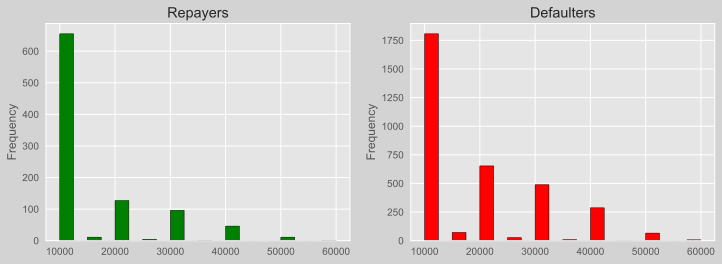

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
Tperfomance[Tperfomance['good_bad_flag'] == 1].loanamount.plot.hist(
    ax=ax[0], bins=20, edgecolor='black', color='green')
ax[0].set_title('Repayers')
Tperfomance[Tperfomance['good_bad_flag'] == 0].loanamount.plot.hist(
    ax=ax[1], color='red', bins=20, edgecolor='black')
ax[1].set_title('Defaulters')
fig.set_facecolor("lightgrey")
plt.show()

In [0]:
print('Highest loan number is:', Tperfomance['loannumber'].max())
print('Lowest loan number is:', Tperfomance['loannumber'].min())
print('Average loan number is:', Tperfomance['loannumber'].mean())
print('Median loan number is:', Tperfomance['loannumber'].median())

Highest loan number is: 34
Lowest loan number is: 2
Average loan number is: 5.151598487452733
Median loan number is: 4.0


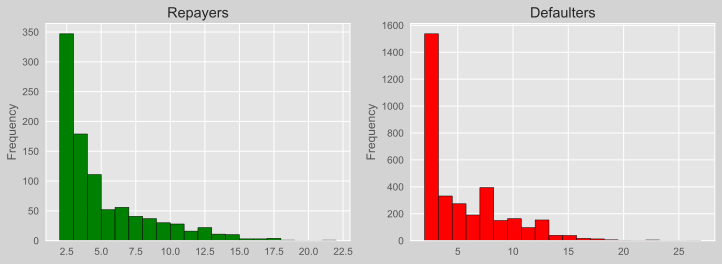

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
Tperfomance[Tperfomance['good_bad_flag'] == 1].loannumber.plot.hist(
    ax=ax[0], bins=20, edgecolor='black', color='green')
ax[0].set_title('Repayers')
Tperfomance[Tperfomance['good_bad_flag'] == 0].loannumber.plot.hist(
    ax=ax[1], color='red', bins=20, edgecolor='black')
ax[1].set_title('Defaulters')
fig.set_facecolor("lightgrey")
plt.show()

#### 4.5 Merge the dataset

In [0]:
#merge data which has attributes from previous loans to performance data
data=pd.merge(data.reset_index(),Tperfomance,how='outer',on='customerid')

##### 4.5.1  Features from merged data

In [0]:
data.head(3)

,customerid,Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,earlypayment,good_bad_flag,loanamount,loannumber,set,termdays,new_profit
0,8a1088a0484472eb01484669e3ce4e0b,"1,500.00","1,500.00","10,000.00",15.00,-7.00,0.00,0.00,"10,000.00",2,train,15,"1,500.00"
1,8a1a1e7e4f707f8b014f797718316cad,"19,500.00","4,875.00","17,500.00",37.50,6.25,3.00,1.00,"30,000.00",5,train,60,"9,000.00"
2,8a1a32fc49b632520149c3b8fdf85139,"16,500.00","2,357.14","12,857.14",19.29,1.00,6.00,1.00,"20,000.00",8,train,30,"4,500.00"


In [0]:
data['loanamountdeviation']=data.Avgloanamount-data.loanamount
data['profitdeviation']=data.Avgprofit-data.new_profit
data['termdaysdeviation']=data.Avgtermdays-data.termdays

In [0]:
data.head(3)

,customerid,Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,earlypayment,good_bad_flag,loanamount,loannumber,set,termdays,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation
0,8a1088a0484472eb01484669e3ce4e0b,"1,500.00","1,500.00","10,000.00",15.00,-7.00,0.00,0.00,"10,000.00",2,train,15,"1,500.00",0.00,0.00,0.00
1,8a1a1e7e4f707f8b014f797718316cad,"19,500.00","4,875.00","17,500.00",37.50,6.25,3.00,1.00,"30,000.00",5,train,60,"9,000.00","-12,500.00","-4,125.00",-22.50
2,8a1a32fc49b632520149c3b8fdf85139,"16,500.00","2,357.14","12,857.14",19.29,1.00,6.00,1.00,"20,000.00",8,train,30,"4,500.00","-7,142.86","-2,142.86",-10.71


In [0]:
#merge data which has attributes from previous & performance loans to demographics data
data=pd.merge(data,Tdemographics,on='customerid',how='inner')

In [0]:
data.tail()

,customerid,Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,earlypayment,good_bad_flag,loanamount,loannumber,set_x,termdays,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,bank_account_type,longitude_gps,latitude_gps,employment_status_clients,level_of_education_clients,set_y,Age_x,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Loan_to_Asset,Status,Time,Merger,Age_y,Revenue,Asset
5813,8a8589005384ab570153880ceba74594,nan,nan,nan,nan,nan,nan,nan,"30,000.00",3,test,60,"9,000.00",nan,nan,nan,Other,3.42,6.44,Permanent,Graduate,train,MiddleAge,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.47,0.00,10.00,0.00,25.00,280.10,"2,520.00"
5814,8a858f2d5853901a01585c79a6021b8f,nan,nan,nan,nan,nan,nan,nan,"30,000.00",2,test,60,"9,000.00",nan,nan,nan,Savings,3.31,6.51,Permanent,Graduate,test,MiddleAge,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.47,0.00,10.00,0.00,25.00,280.10,"2,520.00"
5815,8a858e9f59d692440159da2c60b42106,nan,nan,nan,nan,nan,nan,nan,"20,000.00",2,test,30,"3,000.00",nan,nan,nan,Savings,3.36,6.64,Permanent,Graduate,train,MiddleAge,2.00,0.10,0.01,1.04,0.93,0.49,0.33,0.34,0.00,10.00,1.00,66.00,247.20,"2,750.00"
5816,8a858f0d58a18ebc0158a9bf124b5a30,nan,nan,nan,nan,nan,nan,nan,"10,000.00",2,test,15,"1,500.00",nan,nan,nan,Savings,3.31,6.64,Permanent,Graduate,train,YoungAge,3.00,0.09,0.03,1.12,0.93,0.64,0.14,0.47,0.00,10.00,0.00,25.00,432.50,"4,010.00"
5817,8a85890253e2f1180153eae33e5e6bc3,nan,nan,nan,nan,nan,nan,nan,"20,000.00",3,test,30,"4,500.00",nan,nan,nan,Savings,3.37,6.64,Permanent,Graduate,train,YoungAge,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.47,0.00,10.00,0.00,25.00,280.10,"2,520.00"


In [0]:
data.drop(columns=['set_x','set_y'],inplace=True)

In [0]:
data.shape

(5818, 35)

**<font color="red">really dont know how to use longitude and latitude. i will drop it**

In [0]:
cols=[x for x in data.columns if x not in ['longitude_gps','latitude_gps']]
data=data[cols]

In [0]:
#export the data
data.to_csv('../data/interim/feature_matrix.csv', index=False)

---

## 5. Feature Selection

### 5.1 Correlation

In [0]:
#calculate corelations
correlation =  data.corr()
correlation.to_csv('../data/interim/correlations_spec.csv')

In [0]:
correlations = pd.read_csv('../data/interim/correlations_spec.csv', index_col =0)
correlations.index.name = 'Variable'
correlations.head()

,Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,earlypayment,good_bad_flag,loanamount,loannumber,termdays,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Loan_to_Asset,Status,Time,Merger,Age_y,Revenue,Asset
Variable,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Totalprofit,1.00,0.66,0.92,0.43,0.18,0.90,0.09,0.86,0.94,0.53,0.53,-0.71,-0.24,-0.32,-0.02,0.00,-0.01,0.00,0.00,0.02,0.02,0.01,-0.00,nan,0.01,0.00,-0.03,0.00
Avgprofit,0.66,1.00,0.61,0.93,0.22,0.47,0.05,0.54,0.46,0.60,0.55,-0.43,-0.06,-0.05,-0.01,-0.00,-0.01,0.00,-0.00,-0.00,0.02,-0.01,-0.00,nan,0.01,-0.01,-0.03,-0.02
Avgloanamount,0.92,0.61,1.00,0.33,0.21,0.86,0.10,0.89,0.85,0.48,0.50,-0.70,-0.23,-0.33,-0.01,0.00,-0.01,0.01,0.01,0.03,0.01,0.02,-0.00,nan,0.00,0.01,-0.03,0.01
Avgtermdays,0.43,0.93,0.33,1.00,0.19,0.23,0.02,0.29,0.22,0.53,0.41,-0.23,0.07,0.08,0.00,-0.00,-0.02,-0.00,-0.00,-0.02,0.02,-0.02,-0.00,nan,0.01,-0.02,-0.03,-0.03
Avgdaysleft,0.18,0.22,0.21,0.19,1.00,0.29,0.24,0.23,0.12,0.20,0.17,-0.22,-0.07,-0.10,-0.01,0.01,0.01,0.02,0.01,0.02,0.02,0.00,-0.01,nan,0.01,0.00,-0.03,0.01


In [0]:
#correlation with target
correlations_target = correlations.sort_values('good_bad_flag')['good_bad_flag']
# Most negative correlations
correlations_target.head(5)

Variable
loanamountdeviation   -0.11
Revenue               -0.03
Return_On_Equity      -0.02
Age_y                 -0.01
profitdeviation       -0.01
Name: good_bad_flag, dtype: float64

In [0]:
# Most positive correlations
correlations_target.dropna().tail(5)

Variable
Avgloanamount   0.10
loanamount      0.12
earlypayment    0.15
Avgdaysleft     0.24
good_bad_flag   1.00
Name: good_bad_flag, dtype: float64

##### Visualize Distribution of Correlated Variables

In [0]:
features_sample = pd.read_csv('../data/interim/feature_matrix.csv')
features_sample['good_bad_flag'] = features_sample['good_bad_flag'].fillna(-1).astype(int)
features_sample.head(3)

,customerid,Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,earlypayment,good_bad_flag,loanamount,loannumber,termdays,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,bank_account_type,employment_status_clients,level_of_education_clients,Age_x,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Loan_to_Asset,Status,Time,Merger,Age_y,Revenue,Asset
0,8a1088a0484472eb01484669e3ce4e0b,"1,500.00","1,500.00","10,000.00",15.00,-7.00,0.00,0,"10,000.00",2,15,"1,500.00",0.00,0.00,0.00,Savings,Permanent,Primary,YoungAge,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.47,0.00,10.00,0.00,25.00,280.10,"2,520.00"
1,8a1a1e7e4f707f8b014f797718316cad,"19,500.00","4,875.00","17,500.00",37.50,6.25,3.00,1,"30,000.00",5,60,"9,000.00","-12,500.00","-4,125.00",-22.50,Other,Permanent,Graduate,MiddleAge,nan,nan,nan,nan,nan,nan,nan,nan,0.00,10.00,1.00,16.00,2.10,12.00
2,8a1a32fc49b632520149c3b8fdf85139,"16,500.00","2,357.14","12,857.14",19.29,1.00,6.00,1,"20,000.00",8,30,"4,500.00","-7,142.86","-2,142.86",-10.71,Savings,Permanent,Graduate,MiddleAge,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.47,0.00,10.00,0.00,25.00,280.10,"2,520.00"


In [0]:
def kde_target_plot(df, feature):
    """Kernel density estimate plot of a feature colored
    by value of the target."""
    
    # Need to reset index for loc to workBU
    df = df.reset_index()
    plt.figure(figsize = (10, 6))
    plt.style.use('fivethirtyeight')
    
    # plot repaid loans
    sns.kdeplot(df.loc[df['good_bad_flag'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df.loc[df['good_bad_flag'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of Feature by Target Value')
    plt.xlabel('%s' % feature); 
    plt.ylabel('Density');
    plt.show()

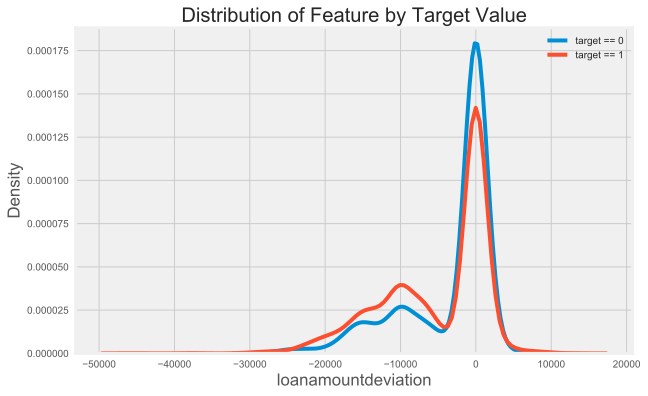

In [0]:
kde_target_plot(features_sample, feature = 'loanamountdeviation')

##### collinear features

In [0]:
threshold = 0.9

correlated_pairs = {}

# Iterate through the columns
for col in correlations:
    # Find correlations above the threshold
    above_threshold_vars = [x for x in list(correlations.index[correlations[col] > threshold]) if x != col]
    correlated_pairs[col] = above_threshold_vars

In [0]:
correlated_pairs['Avgloanamount']

['Totalprofit']

In [0]:
correlations['Avgloanamount'].sort_values(ascending=False).head()

Variable
Avgloanamount   1.00
Totalprofit     0.92
loanamount      0.89
earlypayment    0.86
loannumber      0.85
Name: Avgloanamount, dtype: float64

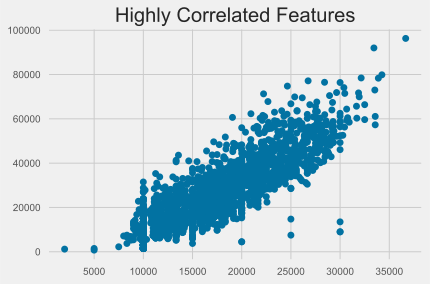

In [0]:
plt.plot(features_sample['Avgloanamount'], features_sample['Totalprofit'], 'bo')
plt.title('Highly Correlated Features');

##### drop correlated features

In [0]:
# Upper triangle of correlations
upper = correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(np.bool))
upper.head()

,Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,earlypayment,good_bad_flag,loanamount,loannumber,termdays,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Loan_to_Asset,Status,Time,Merger,Age_y,Revenue,Asset
Variable,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Totalprofit,nan,0.66,0.92,0.43,0.18,0.90,0.09,0.86,0.94,0.53,0.53,-0.71,-0.24,-0.32,-0.02,0.00,-0.01,0.00,0.00,0.02,0.02,0.01,-0.00,nan,0.01,0.00,-0.03,0.00
Avgprofit,nan,nan,0.61,0.93,0.22,0.47,0.05,0.54,0.46,0.60,0.55,-0.43,-0.06,-0.05,-0.01,-0.00,-0.01,0.00,-0.00,-0.00,0.02,-0.01,-0.00,nan,0.01,-0.01,-0.03,-0.02
Avgloanamount,nan,nan,nan,0.33,0.21,0.86,0.10,0.89,0.85,0.48,0.50,-0.70,-0.23,-0.33,-0.01,0.00,-0.01,0.01,0.01,0.03,0.01,0.02,-0.00,nan,0.00,0.01,-0.03,0.01
Avgtermdays,nan,nan,nan,nan,0.19,0.23,0.02,0.29,0.22,0.53,0.41,-0.23,0.07,0.08,0.00,-0.00,-0.02,-0.00,-0.00,-0.02,0.02,-0.02,-0.00,nan,0.01,-0.02,-0.03,-0.03
Avgdaysleft,nan,nan,nan,nan,nan,0.29,0.24,0.23,0.12,0.20,0.17,-0.22,-0.07,-0.10,-0.01,0.01,0.01,0.02,0.01,0.02,0.02,0.00,-0.01,nan,0.01,0.00,-0.03,0.01


In [0]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to remove.' % (len(to_drop)))

There are 5 columns to remove.


In [0]:
to_drop

['Avgloanamount', 'Avgtermdays', 'earlypayment', 'loannumber', 'Loan_to_Asset']

In [0]:
#columns to drop
features_sample = features_sample.drop(columns = to_drop)
print('data shape: ', features_sample.shape)

data shape:  (5818, 28)


### 5.2 Feature Selection through Feature Importances

We will use a Gradient Boosted Model from the LightGBM library to assess feature importances. 

Since the LightGBM model does not need missing values to be imputed, we can directly fit on the training data. We will use Early Stopping to determine the optimal number of iterations and run the model twice, averaging the feature importances to try and avoid overfitting to a certain set of features.

In [0]:
features_sample.tail(3)

,customerid,Totalprofit,Avgprofit,Avgdaysleft,good_bad_flag,loanamount,termdays,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,bank_account_type,employment_status_clients,level_of_education_clients,Age_x,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Status,Time,Merger,Age_y,Revenue,Asset
5815,8a858e9f59d692440159da2c60b42106,nan,nan,nan,-1,"20,000.00",30,"3,000.00",nan,nan,nan,Savings,Permanent,Graduate,MiddleAge,2.00,0.10,0.01,1.04,0.93,0.49,0.33,0.00,10.00,1.00,66.00,247.20,"2,750.00"
5816,8a858f0d58a18ebc0158a9bf124b5a30,nan,nan,nan,-1,"10,000.00",15,"1,500.00",nan,nan,nan,Savings,Permanent,Graduate,YoungAge,3.00,0.09,0.03,1.12,0.93,0.64,0.14,0.00,10.00,0.00,25.00,432.50,"4,010.00"
5817,8a85890253e2f1180153eae33e5e6bc3,nan,nan,nan,-1,"20,000.00",30,"4,500.00",nan,nan,nan,Savings,Permanent,Graduate,YoungAge,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00"


In [0]:
feature_sample2 = features_sample.copy(deep=True)

In [0]:
feature_sample2.tail(3)

,customerid,Totalprofit,Avgprofit,Avgdaysleft,good_bad_flag,loanamount,termdays,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,bank_account_type,employment_status_clients,level_of_education_clients,Age_x,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Status,Time,Merger,Age_y,Revenue,Asset
5815,8a858e9f59d692440159da2c60b42106,nan,nan,nan,-1,"20,000.00",30,"3,000.00",nan,nan,nan,Savings,Permanent,Graduate,MiddleAge,2.00,0.10,0.01,1.04,0.93,0.49,0.33,0.00,10.00,1.00,66.00,247.20,"2,750.00"
5816,8a858f0d58a18ebc0158a9bf124b5a30,nan,nan,nan,-1,"10,000.00",15,"1,500.00",nan,nan,nan,Savings,Permanent,Graduate,YoungAge,3.00,0.09,0.03,1.12,0.93,0.64,0.14,0.00,10.00,0.00,25.00,432.50,"4,010.00"
5817,8a85890253e2f1180153eae33e5e6bc3,nan,nan,nan,-1,"20,000.00",30,"4,500.00",nan,nan,nan,Savings,Permanent,Graduate,YoungAge,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00"


**dummify the variables**

In [0]:
feature_sample2.tail(3)

,customerid,Totalprofit,Avgprofit,Avgdaysleft,good_bad_flag,loanamount,termdays,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,bank_account_type,employment_status_clients,level_of_education_clients,Age_x,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Status,Time,Merger,Age_y,Revenue,Asset
5815,8a858e9f59d692440159da2c60b42106,nan,nan,nan,-1,"20,000.00",30,"3,000.00",nan,nan,nan,Savings,Permanent,Graduate,MiddleAge,2.00,0.10,0.01,1.04,0.93,0.49,0.33,0.00,10.00,1.00,66.00,247.20,"2,750.00"
5816,8a858f0d58a18ebc0158a9bf124b5a30,nan,nan,nan,-1,"10,000.00",15,"1,500.00",nan,nan,nan,Savings,Permanent,Graduate,YoungAge,3.00,0.09,0.03,1.12,0.93,0.64,0.14,0.00,10.00,0.00,25.00,432.50,"4,010.00"
5817,8a85890253e2f1180153eae33e5e6bc3,nan,nan,nan,-1,"20,000.00",30,"4,500.00",nan,nan,nan,Savings,Permanent,Graduate,YoungAge,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00"


In [0]:
#Dummify the variables
feature_sample2 = pd.get_dummies(feature_sample2, columns=['bank_account_type', 'employment_status_clients','level_of_education_clients',
                                                           'Age_x'], drop_first=True, prefix=['bank_account_type', 
                                                                                              'employment_status_clients',
                                                                                              'level_of_education_clients','Age_x'])

In [0]:
feature_sample2.tail(3)

,customerid,Totalprofit,Avgprofit,Avgdaysleft,good_bad_flag,loanamount,termdays,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Status,Time,Merger,Age_y,Revenue,Asset,bank_account_type_Savings,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,level_of_education_clients_Post-Graduate,level_of_education_clients_Primary,level_of_education_clients_Secondary,Age_x_SeniorAge,Age_x_YoungAge
5815,8a858e9f59d692440159da2c60b42106,nan,nan,nan,-1,"20,000.00",30,"3,000.00",nan,nan,nan,2.00,0.10,0.01,1.04,0.93,0.49,0.33,0.00,10.00,1.00,66.00,247.20,"2,750.00",1,1,0,0,0,0,0,0,0,0,0
5816,8a858f0d58a18ebc0158a9bf124b5a30,nan,nan,nan,-1,"10,000.00",15,"1,500.00",nan,nan,nan,3.00,0.09,0.03,1.12,0.93,0.64,0.14,0.00,10.00,0.00,25.00,432.50,"4,010.00",1,1,0,0,0,0,0,0,0,0,1
5817,8a85890253e2f1180153eae33e5e6bc3,nan,nan,nan,-1,"20,000.00",30,"4,500.00",nan,nan,nan,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00",1,1,0,0,0,0,0,0,0,0,1


In [0]:
train=feature_sample2[(feature_sample2['good_bad_flag'] == 1) | (feature_sample2['good_bad_flag'] == 0)]

In [0]:
test=feature_sample2[feature_sample2['good_bad_flag'] < 0]

In [0]:
print(train.shape)
print(test.shape)

(4368, 35)
(1450, 35)


In [0]:
display(train.head(3))
display(test.head(3))

,customerid,Totalprofit,Avgprofit,Avgdaysleft,good_bad_flag,loanamount,termdays,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Status,Time,Merger,Age_y,Revenue,Asset,bank_account_type_Savings,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,level_of_education_clients_Post-Graduate,level_of_education_clients_Primary,level_of_education_clients_Secondary,Age_x_SeniorAge,Age_x_YoungAge
0,8a1088a0484472eb01484669e3ce4e0b,"1,500.00","1,500.00",-7.00,0,"10,000.00",15,"1,500.00",0.00,0.00,0.00,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00",1,1,0,0,0,0,0,1,0,0,1
1,8a1a1e7e4f707f8b014f797718316cad,"19,500.00","4,875.00",6.25,1,"30,000.00",60,"9,000.00","-12,500.00","-4,125.00",-22.50,nan,nan,nan,nan,nan,nan,nan,0.00,10.00,1.00,16.00,2.10,12.00,0,1,0,0,0,0,0,0,0,0,0
2,8a1a32fc49b632520149c3b8fdf85139,"16,500.00","2,357.14",1.00,1,"20,000.00",30,"4,500.00","-7,142.86","-2,142.86",-10.71,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00",1,1,0,0,0,0,0,0,0,0,0


,customerid,Totalprofit,Avgprofit,Avgdaysleft,good_bad_flag,loanamount,termdays,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Status,Time,Merger,Age_y,Revenue,Asset,bank_account_type_Savings,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,level_of_education_clients_Post-Graduate,level_of_education_clients_Primary,level_of_education_clients_Secondary,Age_x_SeniorAge,Age_x_YoungAge
6,8a28afc7474813a40147639ec637156b,"32,900.00","3,290.00",6.00,-1,"25,000.00",30,"2,500.00","-7,200.00",790.00,1.50,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00",0,1,0,0,0,0,0,0,0,0,0
12,8a3735d5518aba7301518ac34413010d,"18,000.00","3,000.00",13.33,-1,"20,000.00",30,"4,500.00","-8,333.33","-1,500.00",-2.50,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00",0,1,0,0,0,0,0,0,0,0,0
18,8a76e7d443e6e97c0143ed099d102b1d,"3,000.00","1,500.00",1.50,-1,"20,000.00",30,"4,500.00","-10,000.00","-3,000.00",-15.00,3.00,0.09,0.03,1.12,0.93,0.64,0.14,0.00,10.00,0.00,25.00,432.50,"4,010.00",0,1,0,0,0,0,0,0,0,0,0


In [0]:
#rename good_bad
train.rename(columns={'good_bad_flag': 'TARGET'}, inplace=True)
test.rename(columns={'good_bad_flag': 'TARGET'}, inplace=True)

In [0]:
#drop traget column in test
test.drop('TARGET', axis=1, inplace=True)

In [0]:
print(train.shape)
print(test.shape)

(4368, 35)
(1450, 34)


In [0]:
train_labels = train['TARGET']
train_ids = train['customerid']
test_ids = test['customerid']

In [0]:
#remove the customerid
columns = ['customerid']
test.drop(columns, inplace=True, axis=1)
train.drop(columns, inplace=True, axis=1)

In [0]:
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (4368, 34)
Testing shape:  (1450, 33)


**<font color="red">We align the dataframes by the columns. This ensures we have the same columns in the training and testing datasets.**

In [0]:
#We align the dataframes by the columns. This ensures we have the same columns in the training and testing datasets
#Match the columns in the dataframes
train, test = train.align(test, join = 'inner', axis = 1)
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (4368, 33)
Testing shape:  (1450, 33)


In [0]:
display(train.head(3))
display(test.head(3))

,Totalprofit,Avgprofit,Avgdaysleft,loanamount,termdays,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Status,Time,Merger,Age_y,Revenue,Asset,bank_account_type_Savings,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,level_of_education_clients_Post-Graduate,level_of_education_clients_Primary,level_of_education_clients_Secondary,Age_x_SeniorAge,Age_x_YoungAge
0,"1,500.00","1,500.00",-7.00,"10,000.00",15,"1,500.00",0.00,0.00,0.00,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00",1,1,0,0,0,0,0,1,0,0,1
1,"19,500.00","4,875.00",6.25,"30,000.00",60,"9,000.00","-12,500.00","-4,125.00",-22.50,nan,nan,nan,nan,nan,nan,nan,0.00,10.00,1.00,16.00,2.10,12.00,0,1,0,0,0,0,0,0,0,0,0
2,"16,500.00","2,357.14",1.00,"20,000.00",30,"4,500.00","-7,142.86","-2,142.86",-10.71,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00",1,1,0,0,0,0,0,0,0,0,0


,Totalprofit,Avgprofit,Avgdaysleft,loanamount,termdays,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Status,Time,Merger,Age_y,Revenue,Asset,bank_account_type_Savings,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,level_of_education_clients_Post-Graduate,level_of_education_clients_Primary,level_of_education_clients_Secondary,Age_x_SeniorAge,Age_x_YoungAge
6,"32,900.00","3,290.00",6.00,"25,000.00",30,"2,500.00","-7,200.00",790.00,1.50,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00",0,1,0,0,0,0,0,0,0,0,0
12,"18,000.00","3,000.00",13.33,"20,000.00",30,"4,500.00","-8,333.33","-1,500.00",-2.50,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00",0,1,0,0,0,0,0,0,0,0,0
18,"3,000.00","1,500.00",1.50,"20,000.00",30,"4,500.00","-10,000.00","-3,000.00",-15.00,3.00,0.09,0.03,1.12,0.93,0.64,0.14,0.00,10.00,0.00,25.00,432.50,"4,010.00",0,1,0,0,0,0,0,0,0,0,0


#### 5.3.1 Feature Importance

In [0]:
# modeling 
import lightgbm as lgb

# utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

In [0]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(train.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [0]:
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.3, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[41]	valid_0's auc: 0.682547
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[23]	valid_0's auc: 0.686098


In [0]:
# Make sure to average feature importances! 
x = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(train.columns), 
                                    'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

,feature,importance
2,Avgdaysleft,483.00
0,Totalprofit,244.00
1,Avgprofit,168.00
7,profitdeviation,138.00
8,termdaysdeviation,97.00


In [0]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 4 features with 0.0 importance


,feature,importance
26,employment_status_clients_Student,1.00
29,level_of_education_clients_Primary,0.00
17,Time,0.00
31,Age_x_SeniorAge,0.00
24,employment_status_clients_Retired,0.00


It looks like many of the features we made have literally 0 importance. For the gradient boosting machine, features with 0 importance are not used at all to make any splits. Therefore, we can remove these features from the model with no effect on performance.

In [0]:
def plot_feature_importances(df, threshold = 0.9):
    
    plt.rcParams['font.size'] = 14
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (10, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

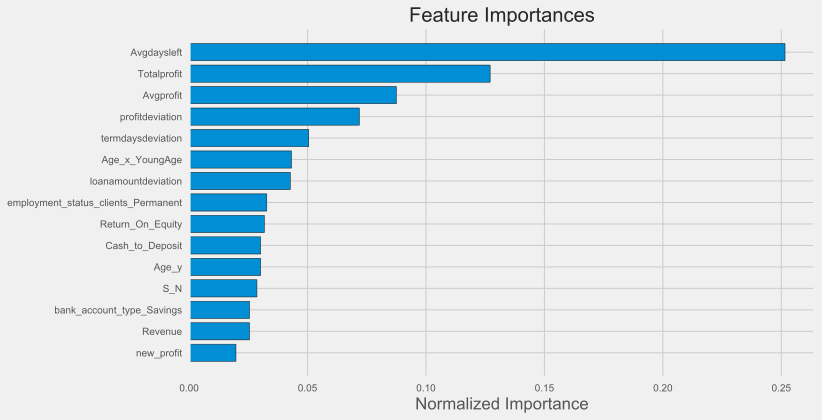

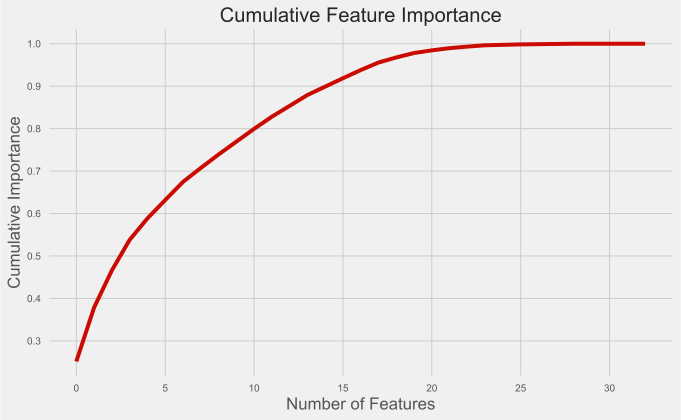

16 features required for 0.90 of cumulative importance


In [0]:
norm_feature_importances = plot_feature_importances(feature_importances)

Let's remove the features that have zero importance.

In [0]:
train = train.drop(columns = zero_features)
test = test.drop(columns = zero_features)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (4368, 29)
Testing shape:  (1450, 29)


At this point, we can re-run the model to see if it identifies any more features with zero importance. In a way, we are implementing our own form of recursive feature elimination. 

In [0]:
def identify_zero_importance_features(train, train_labels, iterations = 2):

    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000,class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):
        
        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [0]:
second_round_zero_features, feature_importances = identify_zero_importance_features(train, train_labels)

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[22]	valid_0's auc: 0.678963
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[4]	valid_0's auc: 0.694201

There are 2 features with 0.0 importance


Now, there are no 0 importance features left. If we want to remove more features, we will create a threshold percentage of importance, such as 95%, to remove less important features.

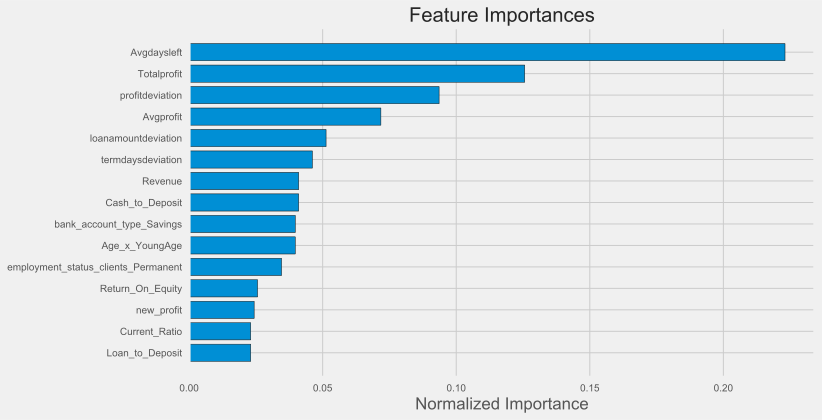

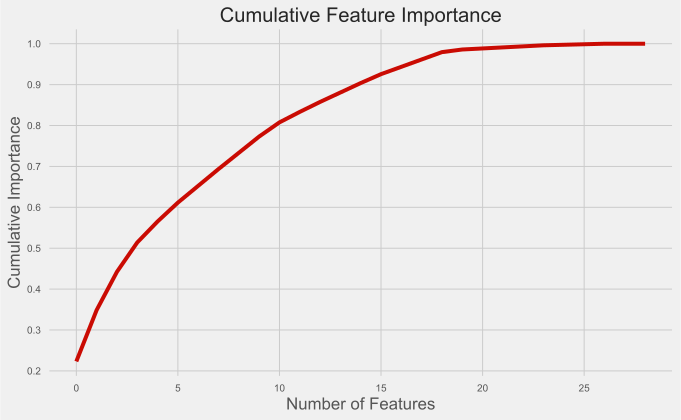

18 features required for 0.95 of cumulative importance


In [0]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

We can keep only the features needed for 95% importance. 

Then, we can test both versions of the data to see if the extra feature removal step is worthwhile.

In [0]:
# Threshold for cumulative importance
threshold = 0.95

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_small = train[features_to_keep]
test_small = test[features_to_keep]

In [0]:
train_small['TARGET'] = train_labels
train_small['customerid'] = train_ids
test_small['customerid'] = test_ids

train_small.to_csv('../data/interim/m_train_small.csv', index = False)
test_small.to_csv('../data/interim/m_test_small.csv', index = False)

---

## 6.0 MODELLING

In [0]:
# Some sklearn tools for preprocessing and building a pipeline. 
# ColumnTransformer was introduced in 0.20 so make sure you have this version
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Our algorithms, by from the easiest to the hardest to intepret.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

In [0]:
features_sample.tail(3)

,customerid,Totalprofit,Avgprofit,Avgdaysleft,TARGET,loanamount,termdays,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,bank_account_type,employment_status_clients,level_of_education_clients,Age_x,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Status,Time,Merger,Age_y,Revenue,Asset
5815,8a858e9f59d692440159da2c60b42106,0.00,0.00,0.00,-1,"20,000.00",30,"3,000.00",0.00,0.00,0.00,Savings,Permanent,Graduate,MiddleAge,2.00,0.10,0.01,1.04,0.93,0.49,0.33,0.00,10.00,1.00,66.00,247.20,"2,750.00"
5816,8a858f0d58a18ebc0158a9bf124b5a30,0.00,0.00,0.00,-1,"10,000.00",15,"1,500.00",0.00,0.00,0.00,Savings,Permanent,Graduate,YoungAge,3.00,0.09,0.03,1.12,0.93,0.64,0.14,0.00,10.00,0.00,25.00,432.50,"4,010.00"
5817,8a85890253e2f1180153eae33e5e6bc3,0.00,0.00,0.00,-1,"20,000.00",30,"4,500.00",0.00,0.00,0.00,Savings,Permanent,Graduate,YoungAge,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00"


In [0]:
features_sample_final = features_sample.copy(deep=True)

In [0]:
#Dummify the variables
# Encoding categorical variables
# create three dummy variables using get_dummies, then exclude the first dummy column
def dummify(col_name, df):
    df_dummies = pd.get_dummies(df[col_name], prefix=col_name).iloc[:, 1:] 
    return df_dummies 

In [0]:
#call the function
dummy_cols = ['bank_account_type','employment_status_clients','level_of_education_clients','Age_x']
for col_name in dummy_cols:
    dummies = dummify(col_name, features_sample_final)
    features_sample_final = pd.concat([features_sample_final, dummies], axis=1) # join the dummy columns to the original df
    features_sample_final = features_sample_final.drop([col_name], axis=1) # drop the original cat. vars column

In [0]:
features_sample_final.tail(3)

,customerid,Totalprofit,Avgprofit,Avgdaysleft,TARGET,loanamount,termdays,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Status,Time,Merger,Age_y,Revenue,Asset,bank_account_type_Savings,employment_status_clients_Contract,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,level_of_education_clients_Graduate,level_of_education_clients_Post-Graduate,level_of_education_clients_Primary,level_of_education_clients_Secondary,Age_x_SeniorAge,Age_x_YoungAge
5815,8a858e9f59d692440159da2c60b42106,0.00,0.00,0.00,-1,"20,000.00",30,"3,000.00",0.00,0.00,0.00,2.00,0.10,0.01,1.04,0.93,0.49,0.33,0.00,10.00,1.00,66.00,247.20,"2,750.00",1,0,1,0,0,0,0,1,0,0,0,0,0
5816,8a858f0d58a18ebc0158a9bf124b5a30,0.00,0.00,0.00,-1,"10,000.00",15,"1,500.00",0.00,0.00,0.00,3.00,0.09,0.03,1.12,0.93,0.64,0.14,0.00,10.00,0.00,25.00,432.50,"4,010.00",1,0,1,0,0,0,0,1,0,0,0,0,1
5817,8a85890253e2f1180153eae33e5e6bc3,0.00,0.00,0.00,-1,"20,000.00",30,"4,500.00",0.00,0.00,0.00,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00",1,0,1,0,0,0,0,1,0,0,0,0,1


In [0]:
#rename good_bad
features_sample_final.rename(columns={'good_bad_flag': 'TARGET'}, inplace=True)

In [0]:
features_sample_final.fillna(0, inplace=True)

In [0]:
features_sample_final.isnull().sum()

customerid                                  0
Totalprofit                                 0
Avgprofit                                   0
Avgdaysleft                                 0
TARGET                                      0
loanamount                                  0
termdays                                    0
new_profit                                  0
loanamountdeviation                         0
profitdeviation                             0
termdaysdeviation                           0
S_N                                         0
Return_On_Equity                            0
Return_On_Asset                             0
Current_Ratio                               0
                                           ..
Revenue                                     0
Asset                                       0
bank_account_type_Savings                   0
employment_status_clients_Contract          0
employment_status_clients_Permanent         0
employment_status_clients_Retired 

In [0]:
features_sample_final.tail(3)

,customerid,Totalprofit,Avgprofit,Avgdaysleft,TARGET,loanamount,termdays,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Status,Time,Merger,Age_y,Revenue,Asset,bank_account_type_Savings,employment_status_clients_Contract,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,level_of_education_clients_Graduate,level_of_education_clients_Post-Graduate,level_of_education_clients_Primary,level_of_education_clients_Secondary,Age_x_SeniorAge,Age_x_YoungAge
5815,8a858e9f59d692440159da2c60b42106,0.00,0.00,0.00,-1,"20,000.00",30,"3,000.00",0.00,0.00,0.00,2.00,0.10,0.01,1.04,0.93,0.49,0.33,0.00,10.00,1.00,66.00,247.20,"2,750.00",1,0,1,0,0,0,0,1,0,0,0,0,0
5816,8a858f0d58a18ebc0158a9bf124b5a30,0.00,0.00,0.00,-1,"10,000.00",15,"1,500.00",0.00,0.00,0.00,3.00,0.09,0.03,1.12,0.93,0.64,0.14,0.00,10.00,0.00,25.00,432.50,"4,010.00",1,0,1,0,0,0,0,1,0,0,0,0,1
5817,8a85890253e2f1180153eae33e5e6bc3,0.00,0.00,0.00,-1,"20,000.00",30,"4,500.00",0.00,0.00,0.00,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00",1,0,1,0,0,0,0,1,0,0,0,0,1


In [0]:
train=features_sample_final[(features_sample_final['TARGET'] == 1) | (features_sample_final['TARGET'] == 0)]

In [0]:
test=features_sample_final[features_sample_final['TARGET'] < 0]

In [0]:
X = train.drop(["customerid", "TARGET"], axis=1)
print("Train Set Shape: {} Rows, {} Columns".format(*X.shape))
test = test.drop(["TARGET"], axis=1)
print("Submission Set Shape: {} Rows, {} Columns".format(*test.shape))
#y = train["TARGET"].values
y = train["TARGET"]

Train Set Shape: 4368 Rows, 35 Columns
Submission Set Shape: 1450 Rows, 36 Columns


In [0]:
X.head(3)

,Totalprofit,Avgprofit,Avgdaysleft,loanamount,termdays,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Status,Time,Merger,Age_y,Revenue,Asset,bank_account_type_Savings,employment_status_clients_Contract,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,level_of_education_clients_Graduate,level_of_education_clients_Post-Graduate,level_of_education_clients_Primary,level_of_education_clients_Secondary,Age_x_SeniorAge,Age_x_YoungAge
0,"1,500.00","1,500.00",-7.00,"10,000.00",15,"1,500.00",0.00,0.00,0.00,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00",1,0,1,0,0,0,0,0,0,1,0,0,1
1,"19,500.00","4,875.00",6.25,"30,000.00",60,"9,000.00","-12,500.00","-4,125.00",-22.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.00,1.00,16.00,2.10,12.00,0,0,1,0,0,0,0,1,0,0,0,0,0
2,"16,500.00","2,357.14",1.00,"20,000.00",30,"4,500.00","-7,142.86","-2,142.86",-10.71,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00",1,0,1,0,0,0,0,1,0,0,0,0,0


In [0]:
y

0       0
1       1
2       1
3       1
4       1
5       1
7       1
8       1
9       1
10      0
11      1
13      1
14      0
15      1
16      1
       ..
5789    1
5790    1
5793    1
5794    1
5795    1
5796    1
5801    1
5802    0
5803    1
5804    0
5805    1
5806    1
5807    0
5808    1
5809    1
Name: TARGET, Length: 4368, dtype: int32

In [0]:
#split the train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.3, random_state=42)

#### Dummy Classifier

* This classifier is useful as a simple baseline to compare with other (real) classifiers. Do not use it for real problems.
* The dummy classifier gives you a measure of "baseline" performance--i.e. the success rate one should expect to achieve even if simply guessing.

Suppose you wish to determine whether a given object possesses or does not possess a certain property. If you have analyzed a large number of those objects and have found that 90% contain the target property, then guessing that every future instance of the object possesses the target property gives you a 90% likelihood of guessing correctly. Structuring your guesses this way is equivalent to using the most_frequent method in the documentation you cite.

In [0]:
from sklearn.dummy import DummyClassifier

In [0]:
clf_dummy = DummyClassifier(strategy="most_frequent")
X_train, X_test, y_train, y_test = train_test_split(X, y)
clf_dummy.fit(X_train, y_train)
clf_dummy.score(X_test, y_test)

0.7838827838827839

### Function to measure the model

In [0]:
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,roc_auc_score,classification_report,roc_auc_score,roc_curve,auc

#Model function
def model(algorithm,dtrain_X,dtrain_Y,dtest_X,dtest_Y,cols=None):

    algorithm.fit(dtrain_X[cols],dtrain_Y)
    predictions = algorithm.predict(dtest_X[cols])
    print (algorithm)
    
    print ("Accuracy score : ", accuracy_score(predictions,dtest_Y))
    print ("Recall score   : ", recall_score(predictions,dtest_Y))
    print ("classification report :\n",classification_report(predictions,dtest_Y))
    
    fig = plt.figure(figsize=(10,8))
    ax  = fig.add_subplot(111)
    prediction_probabilities = algorithm.predict_proba(dtest_X[cols])[:,1]
    fpr , tpr , thresholds   = roc_curve(dtest_Y,prediction_probabilities)
    ax.plot(fpr,tpr,label   = ["Area under curve : ",auc(fpr,tpr)],linewidth=2,linestyle="dotted")
    ax.plot([0,1],[0,1],linewidth=2,linestyle="dashed")
    plt.legend(loc="best")
    plt.title("ROC-CURVE & AREA UNDER CURVE")
    #ax.set_facecolor("k")


#### LogisticRegression

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Accuracy score :  0.7884615384615384
Recall score   :  0.7945334590009425
classification report :
               precision    recall  f1-score   support

           0       0.08      0.58      0.13        31
           1       0.98      0.79      0.88      1061

   micro avg       0.79      0.79      0.79      1092
   macro avg       0.53      0.69      0.51      1092
weighted avg       0.96      0.79      0.86      1092



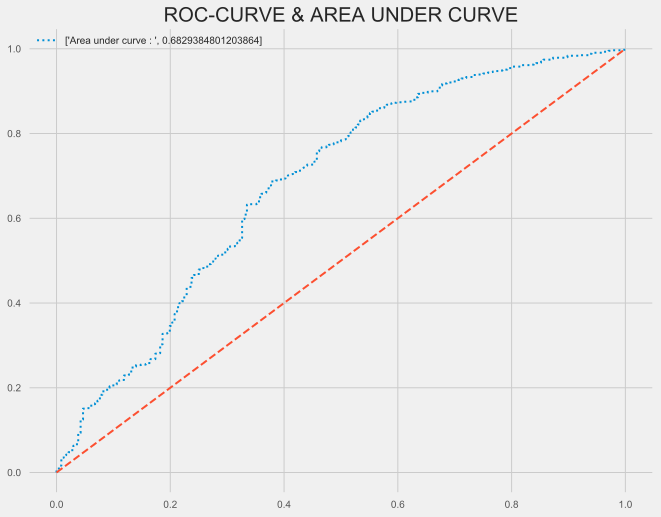

In [0]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression()
model(logit,X_train,y_train,X_test,y_test,X_train.columns)

#### Random Forest Classifier

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy score :  0.760989010989011
Recall score   :  0.8175026680896478
classification report :
               precision    recall  f1-score   support

           0       0.28      0.42      0.33       155
           1       0.89      0.82      0.85       937

   micro avg       0.76      0.76      0.76      1092
   macro avg       0.59      0.62      0.59      1092
weighted avg       0.81      0.76      0.78      1092



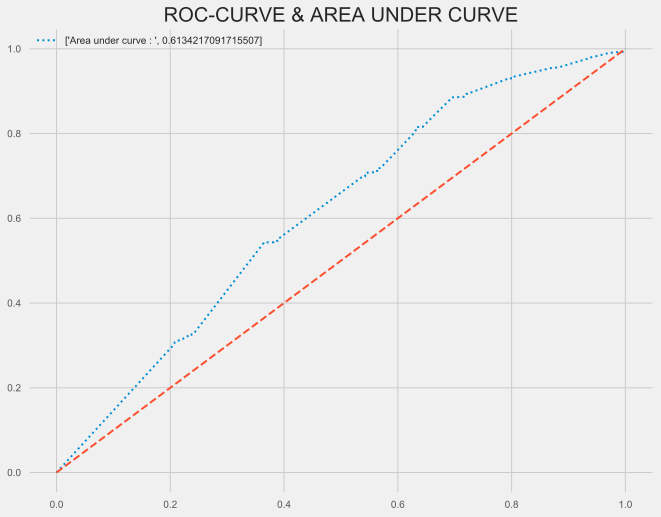

In [0]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
model(rfc,X_train,y_train,X_test,y_test,X_train.columns)

#### Decision Tree Classifier

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Accuracy score :  0.695054945054945
Recall score   :  0.8037166085946573
classification report :
               precision    recall  f1-score   support

           0       0.28      0.29      0.29       231
           1       0.81      0.80      0.81       861

   micro avg       0.70      0.70      0.70      1092
   macro avg       0.55      0.55      0.55      1092
weighted avg       0.70      0.70      0.70      1092



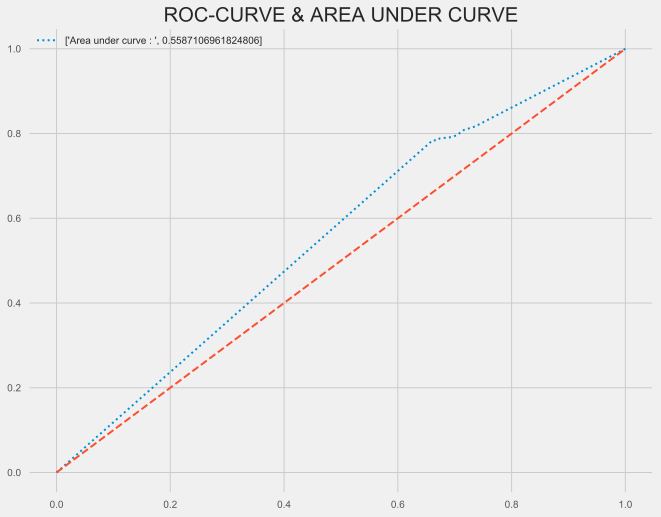

In [0]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
model(dtc,X_train,y_train,X_test,y_test,X_train.columns)

#### Gaussian Naive Bayes

GaussianNB(priors=None, var_smoothing=1e-09)
Accuracy score :  0.7564102564102564
Recall score   :  0.8329571106094809
classification report :
               precision    recall  f1-score   support

           0       0.37      0.43      0.40       206
           1       0.86      0.83      0.85       886

   micro avg       0.76      0.76      0.76      1092
   macro avg       0.62      0.63      0.62      1092
weighted avg       0.77      0.76      0.76      1092



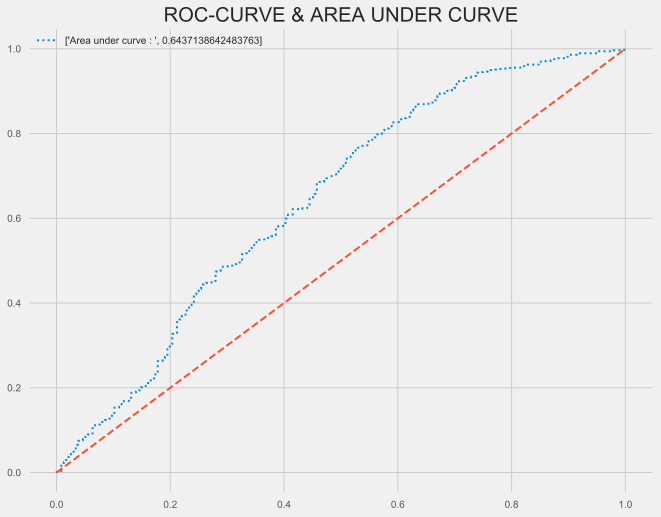

In [0]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
model(gnb,X_train,y_train,X_test,y_test,X_train.columns)

#### XGBoost Classifier

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Accuracy score :  0.7957875457875457
Recall score   :  0.8081791626095424
classification report :
               precision    recall  f1-score   support

           0       0.17      0.60      0.26        65
           1       0.97      0.81      0.88      1027

   micro avg       0.80      0.80      0.80      1092
   macro avg       0.57      0.70      0.57      1092
weighted avg       0.92      0.80      0.84      1092



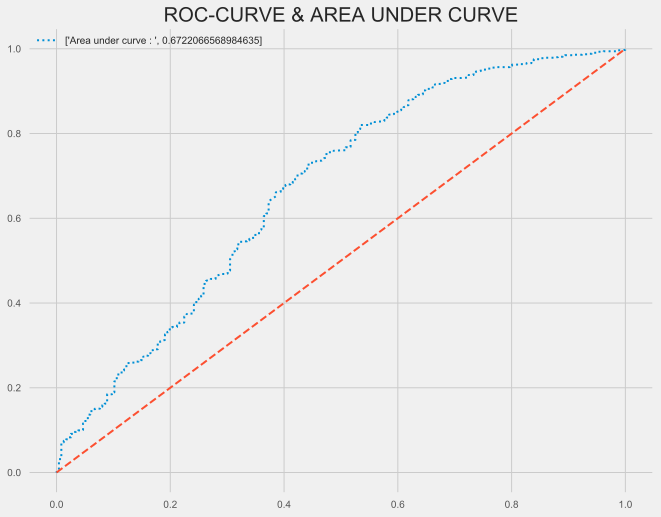

In [0]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
model(xgb,X_train,y_train,X_test,y_test,X_train.columns)

#### Gradient Boosting Classifier

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Accuracy score :  0.793040293040293
Recall score   :  0.8058252427184466
classification report :
               precision    recall  f1-score   support

           0       0.15      0.58      0.24        62
           1       0.97      0.81      0.88      1030

   micro avg       0.79      0.79      0.79      1092
   macro avg       0.56      0.69      0.56      1092
weighted avg       0.92      0.79      0.84      1092



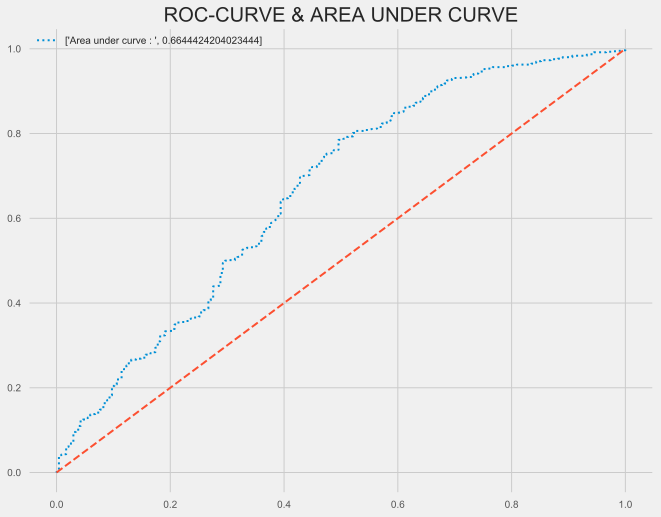

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
model(gbc,X_train,y_train,X_test,y_test,X_train.columns)

**<font color="red">Best model is GradientBoostingClassifier with an AUC of 0.69 but in terms of accuracy it's Loistic regression with accuracy of 0.78**

In [0]:
test.head()

,customerid,Totalprofit,Avgprofit,Avgdaysleft,loanamount,termdays,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Status,Time,Merger,Age_y,Revenue,Asset,bank_account_type_Savings,employment_status_clients_Contract,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,level_of_education_clients_Graduate,level_of_education_clients_Post-Graduate,level_of_education_clients_Primary,level_of_education_clients_Secondary,Age_x_SeniorAge,Age_x_YoungAge
6,8a28afc7474813a40147639ec637156b,"32,900.00","3,290.00",6.00,"25,000.00",30,"2,500.00","-7,200.00",790.00,1.50,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00",0,0,1,0,0,0,0,0,0,0,0,0,0
12,8a3735d5518aba7301518ac34413010d,"18,000.00","3,000.00",13.33,"20,000.00",30,"4,500.00","-8,333.33","-1,500.00",-2.50,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00",0,0,1,0,0,0,0,1,0,0,0,0,0
18,8a76e7d443e6e97c0143ed099d102b1d,"3,000.00","1,500.00",1.50,"20,000.00",30,"4,500.00","-10,000.00","-3,000.00",-15.00,3.00,0.09,0.03,1.12,0.93,0.64,0.14,0.00,10.00,0.00,25.00,432.50,"4,010.00",0,0,1,0,0,0,0,0,0,0,0,0,0
21,8a818823525dceef01525deda2480384,"39,975.00","4,441.67",0.78,"40,000.00",60,"8,000.00","-21,111.11","-3,558.33",-20.00,1.00,0.10,0.01,1.12,0.96,0.89,0.08,0.00,10.00,0.00,121.00,293.00,"4,170.00",1,0,0,0,1,0,0,1,0,0,0,0,0
23,8a818926522ea5ef01523aff15c37482,"6,000.00","3,000.00",-10.50,"20,000.00",30,"4,500.00","-10,000.00","-1,500.00",0.00,6.00,0.06,0.00,1.04,0.86,0.83,0.09,0.00,10.00,1.00,25.00,6.22,"1,750.00",1,0,1,0,0,0,0,0,0,0,1,0,0


---

In [0]:
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport

In [0]:
#xgb, #gbc, #gnb #dtc, #rfc, #logit

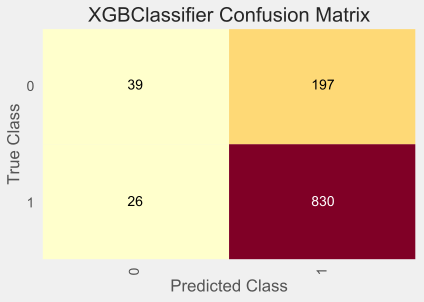

In [0]:
fig, ax = plt.subplots()
cm = ConfusionMatrix(xgb, classes=[0, 1], ax=ax)

#Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

#To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
#and then creates the confusion_matrix from scikit learn.
cm.score(X_test, y_test)

#How did we do?
cm.poof()

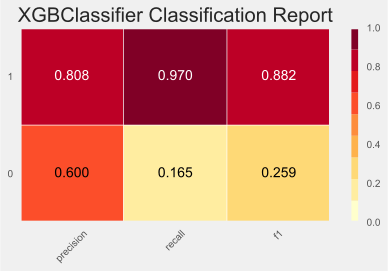

In [0]:
fig, ax = plt.subplots()
visualizer = ClassificationReport(xgb, classes=[0, 1], ax=ax)
ax.grid(False)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

---

In [0]:
test_sub_X = test[[i for i in test.columns if i not in ['customerid']]]
gbc = GradientBoostingClassifier()
gbc.fit(X_train,y_train)
sub_prob = gbc.predict_proba(test_sub_X)[:,1]
sub_prob = pd.DataFrame(sub_prob)
ids = test[["customerid"]]
subm  = ids.merge(sub_prob,left_index=True,right_index=True,how="left")
sample_submission  = subm.rename(columns={"customerid":'customerid',0:'Good_Bad_flag'})

In [0]:
sample_submission.tail()

,customerid,Good_Bad_flag
5813,8a8589005384ab570153880ceba74594,nan
5814,8a858f2d5853901a01585c79a6021b8f,nan
5815,8a858e9f59d692440159da2c60b42106,nan
5816,8a858f0d58a18ebc0158a9bf124b5a30,nan
5817,8a85890253e2f1180153eae33e5e6bc3,nan


In [0]:
sample_submission.to_csv("best_model.csv",index = False)

### Catboost

In [0]:
from catboost import Pool, CatBoostClassifier, cv

In [0]:
features_sample.tail(3)

,customerid,Totalprofit,Avgprofit,Avgdaysleft,good_bad_flag,loanamount,termdays,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,bank_account_type,employment_status_clients,level_of_education_clients,Age_x,S_N,Return_On_Equity,Return_On_Asset,Current_Ratio,Liquid_to_asset_Ratio,Loan_to_Deposit,Cash_to_Deposit,Status,Time,Merger,Age_y,Revenue,Asset
5815,8a858e9f59d692440159da2c60b42106,nan,nan,nan,-1,"20,000.00",30,"3,000.00",nan,nan,nan,Savings,Permanent,Graduate,MiddleAge,2.00,0.10,0.01,1.04,0.93,0.49,0.33,0.00,10.00,1.00,66.00,247.20,"2,750.00"
5816,8a858f0d58a18ebc0158a9bf124b5a30,nan,nan,nan,-1,"10,000.00",15,"1,500.00",nan,nan,nan,Savings,Permanent,Graduate,YoungAge,3.00,0.09,0.03,1.12,0.93,0.64,0.14,0.00,10.00,0.00,25.00,432.50,"4,010.00"
5817,8a85890253e2f1180153eae33e5e6bc3,nan,nan,nan,-1,"20,000.00",30,"4,500.00",nan,nan,nan,Savings,Permanent,Graduate,YoungAge,4.00,0.24,0.04,0.99,0.82,0.71,0.32,0.00,10.00,0.00,25.00,280.10,"2,520.00"


In [0]:
features_sample.fillna(0, inplace=True)

In [0]:
features_sample.columns

Index(['customerid', 'Totalprofit', 'Avgprofit', 'Avgdaysleft',
       'good_bad_flag', 'loanamount', 'termdays', 'new_profit',
       'loanamountdeviation', 'profitdeviation', 'termdaysdeviation',
       'bank_account_type', 'employment_status_clients',
       'level_of_education_clients', 'Age_x', 'S_N', 'Return_On_Equity',
       'Return_On_Asset', 'Current_Ratio', 'Liquid_to_asset_Ratio',
       'Loan_to_Deposit', 'Cash_to_Deposit', 'Status', 'Time', 'Merger',
       'Age_y', 'Revenue', 'Asset '],
      dtype='object')

In [0]:
#rename good_bad
features_sample.rename(columns={'good_bad_flag': 'TARGET'}, inplace=True)

In [0]:
categorical = ['bank_account_type', 'employment_status_clients', 'level_of_education_clients', 'Age_x']

In [0]:
train=features_sample[(features_sample['TARGET'] == 1) | (features_sample['TARGET'] == 0)]

In [0]:
test=features_sample[features_sample['TARGET'] < 0]

In [0]:
X = train.drop(["customerid","TARGET"], axis=1)
print("Train Set Shape: {} Rows, {} Columns".format(*X.shape))
test = test.drop(["TARGET"], axis=1)
print("Submission Set Shape: {} Rows, {} Columns".format(*test.shape))
#y = train["TARGET"].values
y = train["TARGET"]

Train Set Shape: 4368 Rows, 26 Columns
Submission Set Shape: 1450 Rows, 27 Columns


In [0]:
# Prepare Categorical features indices
def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, query_cols, sorter=sidx)]


categorical_features_indices = column_index(X, categorical)

In [0]:
categorical_features_indices

array([ 9, 10, 11, 12], dtype=int64)

In [0]:
# Train/Valid
X_train, X_val, y_train, y_val  = train_test_split(X, y, test_size=0.30, random_state=17)

In [0]:
rnd_state = 42
clf = CatBoostClassifier(random_seed=rnd_state, iterations=80, loss_function='Logloss', custom_metric='Accuracy')
clf.fit(X_train, y_train, cat_features=categorical_features_indices,eval_set=(X_val, y_val),plot=True)
clf.score(X_val, y_val)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5986434	test: 0.5962439	best: 0.5962439 (0)	total: 140ms	remaining: 11.1s
1:	learn: 0.5409096	test: 0.5369052	best: 0.5369052 (1)	total: 256ms	remaining: 9.99s
2:	learn: 0.5094701	test: 0.5053328	best: 0.5053328 (2)	total: 333ms	remaining: 8.55s
3:	learn: 0.4926127	test: 0.4905643	best: 0.4905643 (3)	total: 413ms	remaining: 7.86s
4:	learn: 0.4826117	test: 0.4804877	best: 0.4804877 (4)	total: 492ms	remaining: 7.39s
5:	learn: 0.4750799	test: 0.4759851	best: 0.4759851 (5)	total: 582ms	remaining: 7.17s
6:	learn: 0.4726080	test: 0.4734054	best: 0.4734054 (6)	total: 634ms	remaining: 6.61s
7:	learn: 0.4695180	test: 0.4717169	best: 0.4717169 (7)	total: 706ms	remaining: 6.35s
8:	learn: 0.4656932	test: 0.4713405	best: 0.4713405 (8)	total: 821ms	remaining: 6.48s
9:	learn: 0.4618089	test: 0.4683892	best: 0.4683892 (9)	total: 925ms	remaining: 6.47s
10:	learn: 0.4596030	test: 0.4675311	best: 0.4675311 (10)	total: 1.01s	remaining: 6.33s
11:	learn: 0.4582654	test: 0.4680791	best: 0.4675311

0.8077803203661327

#### CatBoost model training

* cat_features — This parameter is a must in order to leverage Catboost preprocessing of categorical features, if you encode the categorical features yourself and don’t pass the columns indices as cat_features you are missing the essence of Catboost.

* one_hot_max_size — As mentioned before, Catboost uses a one-hot encoding for all features with at most one_hot_max_size unique values. In our case, the categorical features have a lot of unique values, so we won’t use one hot encoding, but depending on the dataset it may be a good idea to adjust this parameter.

* learning_rate & n_estimators — The smaller the learning_rate, the more n_estimators needed to utilize the model. Usually, the approach is to start with a relative high learning_rate, tune other parameters and then decrease the learning_rate while increasing n_estimators.

* max_depth — Depth of the base trees, this parameter has an high impact on training time.

* subsample — Sample rate of rows, can’t be used in a Bayesian boosting type setting.

* colsample_bylevel — Sample rate of columns.

* l2_leaf_reg — L2 regularization coefficient

* random_strength — Every split gets a score and random_strength is adding some randomness to the score, it helps to reduce overfitting.

In [0]:
clf =  CatBoostClassifier(iterations=1000,
                             learning_rate=0.01,
                             depth=16,
                             eval_metric='Accuracy',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100)
clf.fit(X_train, y_train,
                 eval_set=(X_val, y_val),
                 cat_features=categorical_features_indices,
                 use_best_model=True)

0:	learn: 0.7903173	test: 0.7856598	best: 0.7856598 (0)	total: 754ms	remaining: 12m 33s
75:	learn: 0.7952241	test: 0.8001526	best: 0.8100686 (2)	total: 57.2s	remaining: 11m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8100686499
bestIteration = 2

Shrink model to first 3 iterations.


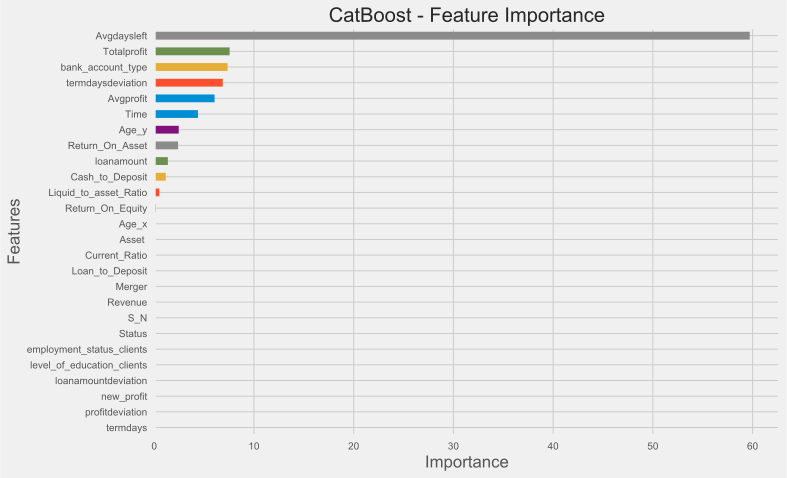

In [0]:
fea_imp = pd.DataFrame({'imp': clf.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

In [0]:
fea_imp

,imp,col
4,0.00,termdays
7,0.00,profitdeviation
5,0.00,new_profit
6,0.00,loanamountdeviation
11,0.00,level_of_education_clients
10,0.00,employment_status_clients
20,0.00,Status
13,0.00,S_N
24,0.00,Revenue
22,0.00,Merger


In [0]:
# Submission 1: catboost submission with all training data and early stopping on Accuracy
test_df = test.set_index('customerid')
#test_df.fillna(-999, inplace=True)
test_df.fillna(test_df.mean(), inplace=True)
clf_od = CatBoostClassifier(random_seed=rnd_state, od_type='Iter', od_wait=20, eval_metric='Accuracy')
clf_od.fit(X_train, y_train, cat_features=categorical_features_indices,eval_set=(X_val, y_val),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7877004	test: 0.7963387	best: 0.7963387 (0)	total: 93.6ms	remaining: 1m 33s
1:	learn: 0.7896631	test: 0.7963387	best: 0.7963387 (0)	total: 159ms	remaining: 1m 19s
2:	learn: 0.7971868	test: 0.8016781	best: 0.8016781 (2)	total: 224ms	remaining: 1m 14s
3:	learn: 0.7942427	test: 0.7963387	best: 0.8016781 (2)	total: 287ms	remaining: 1m 11s
4:	learn: 0.7945698	test: 0.7971014	best: 0.8016781 (2)	total: 366ms	remaining: 1m 12s
5:	learn: 0.7998037	test: 0.8009153	best: 0.8016781 (2)	total: 444ms	remaining: 1m 13s
6:	learn: 0.7971868	test: 0.7986270	best: 0.8016781 (2)	total: 498ms	remaining: 1m 10s
7:	learn: 0.7994766	test: 0.7993898	best: 0.8016781 (2)	total: 562ms	remaining: 1m 9s
8:	learn: 0.7968597	test: 0.7986270	best: 0.8016781 (2)	total: 637ms	remaining: 1m 10s
9:	learn: 0.7971868	test: 0.7978642	best: 0.8016781 (2)	total: 675ms	remaining: 1m 6s
10:	learn: 0.8014393	test: 0.8009153	best: 0.8016781 (2)	total: 745ms	remaining: 1m 6s
11:	learn: 0.8017664	test: 0.8009153	best: 0

In [0]:
submission = pd.DataFrame()
submission['customerid'] = test_df.index
submission['Good_Bad_flag'] = clf.predict(test_df).astype('int')
submission.to_csv('../data/submission/submission_early_stopping.csv', index=False)

---